In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats,interpolate
import copy
import os
from datetime import datetime
from KaixinSpecTools import *

In [50]:
cd '/home/kaixin/Documents/23NaHe3d_Analysis'

/home/kaixin/Documents/23NaHe3d_Analysis


In [51]:
level='10821'
# method='twol'
method='zero_range'
# method='j1'
# method='pi-'
# method='1p12'
path_main='/home/kaixin/Documents/23NaHe3d_Analysis' # directory to run fresco and generate fort.201, fort.202 files
path_specdata=path_main+'/SpecData' # directory where the datafiles are stored
path_fresco_input=path_main+'/FrescoInputFiles' # directory for fresco input files
path_fresco_temp=path_main+'/FrescoTemp' # directory to run fresco and create temporary output files
path_plots=path_main+'/Plots'
#path_fresco_data=path_fresco+'/FrescoInputData' # directory for yield data used for fitting optical model parameters in fresco input. Not using now.

In [52]:
"""Copied from pfunk"""
class Angles():
    def __init__(self, theta, sigma):
        self.theta = np.asarray(theta, dtype='float64')
        self.sigma = np.asarray(sigma, dtype='float64')
class LineObject(Angles):
    def __init__(self, theta, sigma):
        Angles.__init__(self, theta, sigma)
class DataObject(Angles):
    def __init__(self, theta, sigma, erry):
        Angles.__init__(self, theta, sigma)
        self.erry = np.asarray(erry)
def read_cross(filename):
    cross = pd.read_csv(filename, sep='\s+', skiprows=10, header=None)
    theta = cross[cross.columns[0]].tolist()[:-1]
    sigma = cross[cross.columns[1]].tolist()[:-1]
    graphline = LineObject(theta, sigma)
    return graphline
def filerun(filepath):
    command = 'fresco' + '<' + filepath + '> out.txt'
    os.system(command)
def read_data(filename, delim=None):
    if delim:
        data = pd.read_csv(filename, sep=delim)
    else:
        data = pd.read_csv(filename, sep='\s+')
    theta = data[data.columns[0]].tolist()
    sigma = data[data.columns[1]].tolist()
    try:
        erry = data[data.columns[2]]
        erry[erry == 0.0] = 1.e-6
        erry = erry.tolist()
    except IndexError:
        erry = None
    graphline = DataObject(theta, sigma, erry)
    return graphline

In [53]:
if method=='zero_range':
    method=''
else:
    method='_'+method
fresco_path = path_main+'/FrescoInputFiles/Na23He3d_'+level+'keV'+method+'.in'
#fresco_path = './new_input'
elastic_data_path = path_main+'/FrescoInputData/23Na-3He-ES.data'
transfer_data_path = path_main+'/FrescoInputData/23Na-3He-d-'+level+'keV.data'

In [54]:
now = datetime.now()
current_time = now.strftime("%Y%m%d_%H:%M")
os.chdir(path_fresco_temp)
try:
    os.mkdir(current_time)
except:
    print('Using the same directory') 
os.chdir(current_time)
cpcommand='cp '+fresco_path+' '+path_fresco_temp+'/'+current_time+'/input.txt'
print(cpcommand)
os.system(cpcommand)

cp /home/kaixin/Documents/23NaHe3d_Analysis/FrescoInputFiles/Na23He3d_10821keV.in /home/kaixin/Documents/23NaHe3d_Analysis/FrescoTemp/20250701_16:55/input.txt


0

In [55]:
pwd

'/home/kaixin/Documents/23NaHe3d_Analysis/FrescoTemp/20250701_16:55'

In [56]:

filerun(fresco_path)
print('Fresco run')

Fresco run


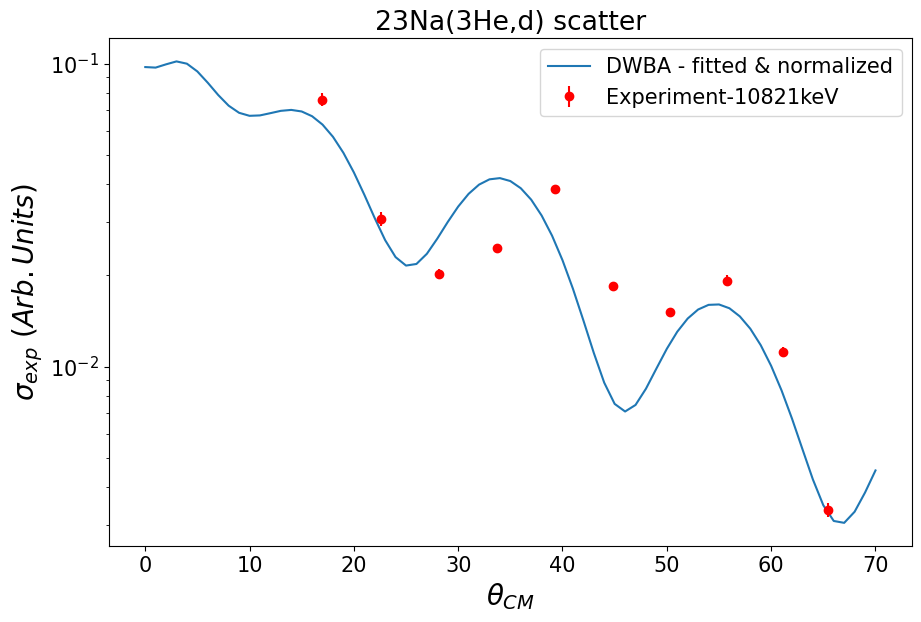

In [57]:
frescoES = read_cross('./fort.201')
expES=read_data(elastic_data_path)
spline = interpolate.UnivariateSpline(frescoES.theta,frescoES.sigma,s=0)
chi2_fit_ES=Minimizations.ScaleMinimize(expES,frescoES)
scale_ES=chi2_fit_ES.x
plt.figure(figsize=(9.5, 6.5))
plt.rcParams['font.size'] = '16'
plt.title('23Na(3He,d) scatter')
plt.plot(frescoES.theta, spline(frescoES.theta)/scale_ES, label='DWBA - fitted & normalized', lw=1.5)
plt.errorbar(expES.theta, expES.sigma, expES.erry, label='Experiment-'+level+'keV',fmt='o', color='red')
plt.yscale('log')
plt.legend(fontsize=15)
plt.xticks(fontsize=15.0)
plt.yticks(fontsize=15.0)
plt.xlabel('$\\theta_{CM}$', fontsize=20.0)
plt.ylabel('$\sigma_{exp}\ (Arb.Units)$', fontsize=20.0)
plt.tight_layout()
plt.savefig(path_plots+'/ES-'+level+'keV.png')

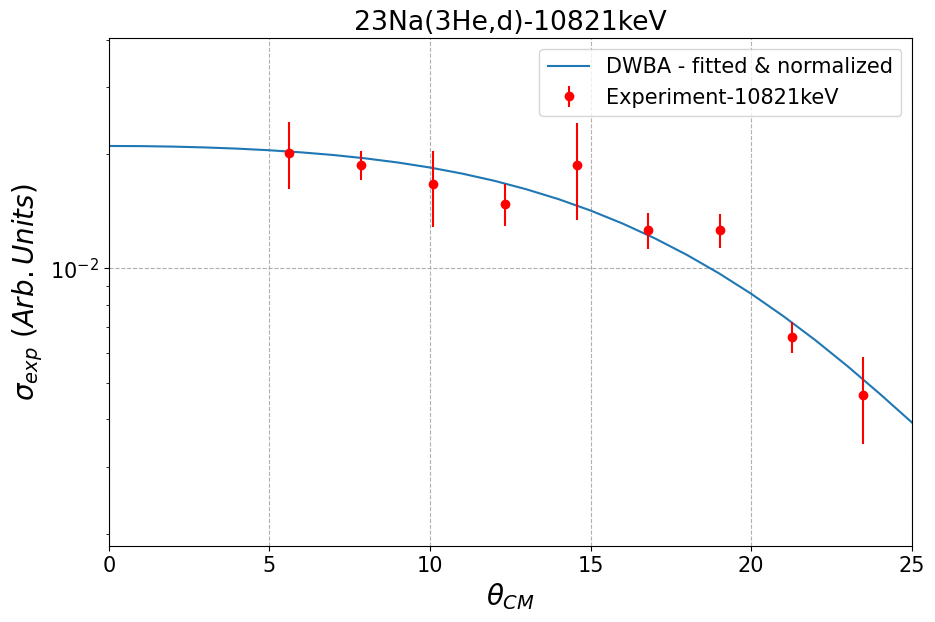

In [58]:
# alpha=0.5
expTR=read_data(transfer_data_path)
frescoTR1 = read_cross('./fort.202')
if (method=='_twol'):
    frescoTR2 = read_cross('./fort.203')
    chi2_fit_twol=Minimizations.AlphaMinimize(expTR,frescoTR1,frescoTR2,LogScale=False)
    [scale_trans,alpha]=chi2_fit_twol.x
else:
    frescoTR2 = frescoTR1
    alpha=0.9
fresco_theta =frescoTR1.theta
fresco_sigma =alpha*frescoTR1.sigma+(1-alpha)*frescoTR2.sigma
frescoTR1.sigma=fresco_sigma
plt.figure(figsize=(9.5, 6.5))
chi2_fit=Minimizations.ScaleMinimize(expTR,frescoTR1)
scale_trans=chi2_fit.x
# plt.plot(theta1,sigma1, label='DWBA - Global', lw=1.5)
plt.plot(fresco_theta,fresco_sigma/scale_trans, label='DWBA - fitted & normalized', lw=1.5)
plt.errorbar(expTR.theta, expTR.sigma, expTR.erry, label='Experiment-'+level+'keV',fmt='o', color='r')
if (method=='_twol'):
    plt.plot(frescoTR1.theta,(alpha)*frescoTR1.sigma/scale_trans, label='DWBA1', lw=1.5)
    plt.plot(frescoTR2.theta,(1-alpha)*frescoTR2.sigma/scale_trans, label='DWBA2', lw=1.5)
    print('alpha=',alpha)
plt.title('23Na(3He,d)-'+level+'keV')
plt.yscale('log')
plt.legend(fontsize=15,loc='best')
plt.xticks(fontsize=15.0)
plt.yticks(fontsize=15.0)
plt.xlabel('$\\theta_{CM}$', fontsize=20.0)
plt.ylabel('$\sigma_{exp}\ (Arb.Units)$', fontsize=20.0)
plt.tight_layout()
plt.xlim([0, 25])
plt.grid(which='major', axis='both',linestyle='--')
# plt.ylim([0.7*min(expTR.sigma), 1.5*max(expTR.sigma)])
plt.ylim([0.4*min(expTR.sigma), 2*max(expTR.sigma)])
if (method=='_twol'):
    plt.ylim([0.2*min(expTR.sigma), 2*max(expTR.sigma)])
plt.savefig(path_plots+'/Trans-'+level+'keV.png')

In [59]:
exp_theta_b=[int(np.floor(i)) for i in expTR.theta]
exp_theta_u=[int(np.ceil(i)) for i in expTR.theta]
exp_err=expTR.erry.tolist()
Deviation=0
for i in range(0,len(expTR.theta)):
    x1=exp_theta_b[i]
    y1=fresco_sigma[exp_theta_b[i]]
    x2=exp_theta_u[i]
    y2=fresco_sigma[exp_theta_u[i]]
    inserted_sigma=(expTR.theta[i]-x1)/(x2-x1)*(y2-y1)+y1
    Deviation=Deviation+(scale_trans*expTR.sigma[i]-inserted_sigma)**2/inserted_sigma
#     Deviation=Deviation+(scale_trans*expTR.sigma[i]-inserted_sigma)**2/exp_err[i]**2
#     print((scale_trans*expTR.sigma[i]-inserted_sigma)**2/exp_err[i]**2)
# print(Deviation)

# level='11933'
# method=''
# fresco_path = path_main+'/FrescoInputFiles/Na23He3d_'+level+'keV'+method+'.in'
# filerun(fresco_path)
data=pd.read_csv('fort.46',index_col=False,skiprows=1,skipfooter=1\
                 ,lineterminator='\n',delim_whitespace=True,header=None,names=['R','ANC','u(R)','Unknown2','Unknown3','Unknown4'])
if (method=='_twol'):
    print('scale=',scale_trans)
#     print('chi2_trans=',Deviation)
#     print('chi2_trans=',chi2_fit_twol.fun)
    print('Reduced_chi2_trans=',Deviation/(len(expTR.theta)-1))

    print('C2S =',scale_ES/scale_trans*(alpha),scale_ES/scale_trans*(1-alpha))
    if len(data['ANC'])==0:
        print('Error printing ANC. Please set ipc=1 in &OVERLAP in the FRESCO input fule.')
    else:
        print('ANC =', data['ANC'][0],data['ANC'][1])
else:
#     print('scales=', scale_ES,scale_trans)
#     print('chi2_trans=',Deviation)
#     print('chi2: Trans=',chi2_fit_ES.fun/len(expES.theta))
#     print('chi2_trans=',chi2_fit.fun)
    print('Reduced_chi2_trans=',Deviation/(len(expTR.theta)-1))
    print('C2S =',scale_ES/scale_trans)
#     print('ANC =', data['ANC'][-1])
    if len(data['ANC'])==0:
        print('Error printing ANC. Please set ipc=1 in &OVERLAP in the FRESCO input file.')
    else:
        print('ANC =', data['ANC'].to_list()[-1])
#     print('ANC_exp=',np.sqrt(scale_ES/scale_trans)*data['ANC'][0])

Reduced_chi2_trans= [0.51917258]
C2S = [0.0063789]
Error printing ANC. Please set ipc=1 in &OVERLAP in the FRESCO input file.


/tmp/ipykernel_17108/3534502523.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data=pd.read_csv('fort.46',index_col=False,skiprows=1,skipfooter=1\
/tmp/ipykernel_17108/3534502523.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data=pd.read_csv('fort.46',index_col=False,skiprows=1,skipfooter=1\


In [60]:
0.00532094

0.00532094

In [61]:
# #varying r
# print('{:.2f}'.format(0.11279398/0.08109019-1),'{:.2f}'.format(2.6136/3.10852-1))
# print('{:.2f}'.format(0.05836359/0.08109019-1),'{:.2f}'.format(3.6917/3.10852-1))
# #varying a
# print('{:.2f}'.format(0.09230784/0.08109019-1),'{:.2f}'.format(2.90134/3.10852-1))
# print('{:.2f}'.format(0.07087601/0.08109019-1),'{:.2f}'.format(3.34161/3.10852-1))

C2S of 9146keV 1-:
1p1/2: 0.01650722
1p3/2: 0.01405553
2p3/2: 0.00651527
2p1/2: 0.00692536

8437keV 4+ and 1-:
1d5/2+2p3/2: 0.02628624, 0.0663594
1d5/2+1p1/2: 0.06431707 0.06775998

In [62]:
# frescoTR1.sigma

In [63]:
#Print wave function

In [64]:
df=pd.read_csv('./fort.58',skiprows=5,names=['R','u(R)'],delim_whitespace=True)
df=df[:-2]
R0=1.25*(23**(1/3)) # R0=1.25 A^(1/3) for Woods-Saxon potential
index=0
dev=100
for i in range(0,len(df)):
    if abs(float(df['R'][i])-R0)<dev:
        dev=abs(float(df['R'][i])-R0)
        index=i
x=np.array(df['R'])
x=x.astype(float)
y=np.array(df['u(R)'])
y=y.astype(float)
plt.plot(x[0:400],y[0:400],label='FRESCO')

# plt.xscale('log')
# plt.xticks([0.5,1.0,5.0,10])
# plt.show()

# For comparing with dircap.
data=pd.read_csv('~/Downloads/dircap_new/dircap.out',skiprows=25,\
                 delim_whitespace=True,names=["R","bs","ubs","multi",'intg'])
radius=data["R"].to_numpy().tolist()
bswavefunc=data["bs"].to_numpy().tolist()
def Convert(lst):
    return [ -float(i) for i in lst ]
bswavefunc=Convert(bswavefunc)
plt.plot(radius,bswavefunc,label='dircap')
plt.xscale('log')
plt.axvline(x[index],linestyle='--',color = 'r', label = 'R0')
plt.axhline(y[index],linestyle='--',color = 'black', label = 'f(R0)')
plt.legend(loc='lower left')
plt.title("bs wave function for 1369keV-2s1/2")
plt.xlim(0.1,50)

# end of comparing



/tmp/ipykernel_17108/723539517.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv('./fort.58',skiprows=5,names=['R','u(R)'],delim_whitespace=True)


FileNotFoundError: [Errno 2] No such file or directory: './fort.58'

In [ ]:
R0

In [ ]:
ls